In [13]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [17]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [18]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [19]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [20]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [21]:
len(y_val)

1409

In [22]:
(y_val == churn_decision).mean()

0.8034066713981547

In [23]:
1132/ 1409

0.8034066713981547

### Sklearn has its own accuracy score function

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

### This calculates the accuracy for different thresholds

In [26]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


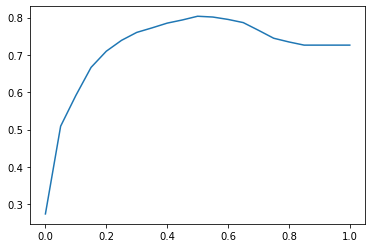

In [27]:
plt.plot(thresholds, scores)

### We count how many false values and how many true values

In [28]:
from collections import Counter

### Is 0.5 a good decision threshold or not? If set to 1, we assume all customers are going to churn. The accuracy is still pretty decent.

In [29]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

### Our model: 80%, Dummy model: 73%. Accuracy doesnt tell us how good the model is. We are just predicting the majority class which is misleading for datasets with class imbalance (There are more False than True or vice versa). 

In [30]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

### We need to have a different way of evaluating our model without being affected by class imbalance.

# ![Confusion Table](Confusion_Table.png)

### In the above diagram, green is correct prediction, red is incorrect prediction.

#### True positive -> correctly predicted true

#### True negative -> correctly predicted false

#### False positive -> true predicted as false

#### False negative -> false predicted as true

![Confusion Table 2](Confusion_Table2.png)

In [31]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [32]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [33]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [34]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [35]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

![Confusion Table 3](Confusion_Table3.png)

## 4.4 Precision and Recall

### Precision is the fraction of positive predictions that are correct.

In [36]:
p = tp / (tp + fp)
p

0.6752411575562701

### Recall is the fraction of correctly predicted outcomes.

In [37]:
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC Curves

### TPR and FRP

### False positive rate is the fraction of false positives among all positive examples. 

### True positive rate is the fraction of true positive among all positive predictions.

### We want false positives to be as small as possible. We want to make true positive rate to be as high as possible.

In [38]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [39]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [40]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [41]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

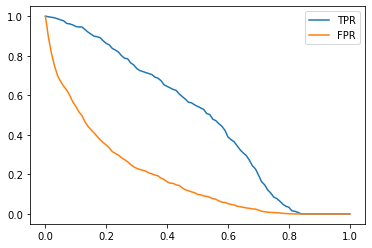

In [42]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [43]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [44]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [45]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [46]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

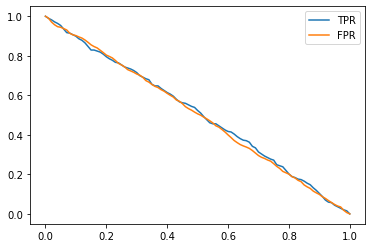

In [47]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [48]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [49]:

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [50]:
1 - y_val.mean()

0.7260468417317246

In [51]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [52]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


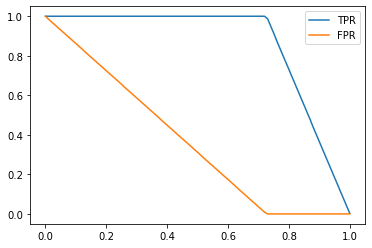

In [53]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

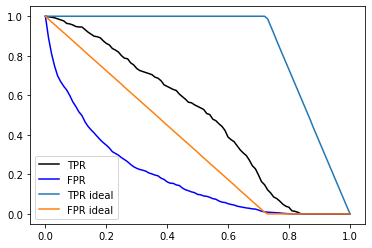

In [54]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

### Plot of TPR vs FPR

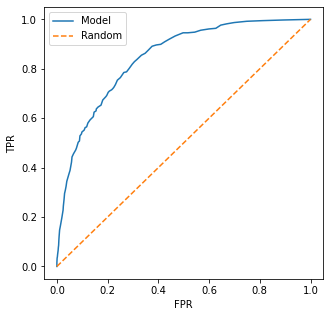

In [55]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [56]:
from sklearn.metrics import roc_curve

In [57]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.77517107e-04,
       9.77517107e-04, 1.95503421e-03, 1.95503421e-03, 2.93255132e-03,
       2.93255132e-03, 3.91006843e-03, 3.91006843e-03, 4.88758553e-03,
       4.88758553e-03, 5.86510264e-03, 5.86510264e-03, 6.84261975e-03,
       6.84261975e-03, 7.82013685e-03, 7.82013685e-03, 9.77517107e-03,
       9.77517107e-03, 1.07526882e-02, 1.07526882e-02, 1.27077224e-02,
       1.27077224e-02, 1.36852395e-02, 1.36852395e-02, 1.46627566e-02,
       1.46627566e-02, 1.66177908e-02, 1.66177908e-02, 1.75953079e-02,
       1.75953079e-02, 1.85728250e-02, 1.85728250e-02, 1.95503421e-02,
       1.95503421e-02, 2.05278592e-02, 2.05278592e-02, 2.15053763e-02,
       2.15053763e-02, 2.24828935e-02, 2.24828935e-02, 2.34604106e-02,
       2.34604106e-02, 2.44379277e-02, 2.44379277e-02, 2.54154448e-02,
       2.54154448e-02, 2.83479961e-02, 2.83479961e-02, 2.93255132e-02,
       2.93255132e-02, 3.03030303e-02, 3.03030303e-02, 3.12805474e-02,
      

### We want our model to be as close as possible to the ideal curve and as far as possible from the random baseline. 

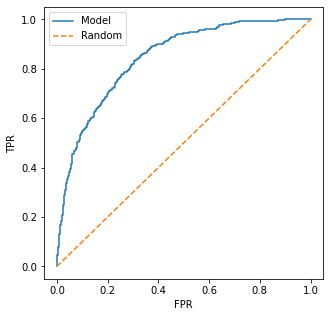

In [58]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

![Area under the curve](Area_Under_the_Curve.png)

In [59]:
from sklearn.metrics import auc

In [60]:
auc(fpr, tpr)

0.843850505725819

In [62]:
auc(df_scores.fpr, df_scores.tpr)

0.8438796286447967

In [63]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [68]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.843850505725819

In [65]:
from sklearn.metrics import roc_auc_score

In [66]:
roc_auc_score(y_val, y_pred)

0.843850505725819

In [70]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [73]:
import random

In [82]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.8434

In [90]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## 4.7 Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [121]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [123]:
dv, model = train(df_train, y_train, C=0.001)

In [110]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [98]:
y_pred = predict(df_val, dv, model)

In [99]:
from sklearn.model_selection import KFold

In [112]:
!pip install tqdm

You should consider upgrading via the '/home/alexey/.pyenv/versions/3.8.11/bin/python3.8 -m pip install --upgrade pip' command.


In [113]:
from tqdm.auto import tqdm

In [129]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


In [133]:
scores

[0.8419433083969826,
 0.8458047775129122,
 0.8325145494681918,
 0.8325466042079682,
 0.8525462018763139]

In [131]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## 4.8 Summary

* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week